# Simple MLP with no hidden layer and 10 output neurons with softmax

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
import sys
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

In [5]:
#you could also get data from the web, this way
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

dir="MNIST_data/"
# Import data
mnist = input_data.read_data_sets(dir, one_hot=True)
mnist.train.images.shape
mnist.train.labels.shape
mnist.test.images.shape
mnist.test.labels.shape

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 784)

(55000, 10)

(10000, 784)

(10000, 10)

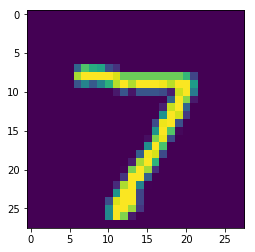

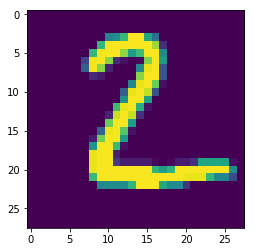

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
from matplotlib import pyplot as plt
import numpy as np
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d)
    return plt

gen_image(mnist.test.images[0]).show()
gen_image(mnist.test.images[1]).show()
print(mnist.test.labels[0], mnist.test.labels[1])

In [8]:
# Create the model
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

In [11]:
# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
# Train
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [8]:
# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images,
                                  y_: mnist.test.labels}))

0.9183


# MLP with multiple hidden layers

In [16]:
import sys
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import time
import math

dir="MNIST_data/"
NUM_CLASSES = 10
# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE
batch_size=100
hidden1=128
hidden2=32
learning_rate=0.01
log_dir="logs/"
max_steps=5000

In [17]:
#Generate placeholder variables to represent the input tensors.
def placeholder_inputs(batch_size):
  images_placeholder = tf.placeholder(tf.float32, shape=(batch_size, IMAGE_PIXELS))
  labels_placeholder = tf.placeholder(tf.int32, shape=(batch_size))
  return images_placeholder, labels_placeholder

In [18]:
#Fills the feed_dict for training the given step with the next "batch size" examples
def fill_feed_dict(data_set, images_pl, labels_pl):
  images_feed, labels_feed = data_set.next_batch(batch_size)
  feed_dict = {
      images_pl: images_feed,
      labels_pl: labels_feed,
  }
  return feed_dict

In [19]:
#Runs one evaluation against the full epoch of data.
#do_eval(sess,eval_correct,images_placeholder,labels_placeholder,data_sets.train)
def do_eval(sess,eval_correct,images_placeholder,labels_placeholder,data_set):
  true_count = 0  # Counts the number of correct predictions.
  steps_per_epoch = data_set.num_examples // batch_size
  num_examples = steps_per_epoch * batch_size
  for step in range(steps_per_epoch):
    feed_dict = fill_feed_dict(data_set,images_placeholder,labels_placeholder)
    true_count += sess.run(eval_correct, feed_dict=feed_dict)
  precision = float(true_count) / num_examples
  print('  Num examples: %d  Num correct: %d  Precision @ 1: %0.04f' %
        (num_examples, true_count, precision))

In [20]:
#Build the MNIST model
def inference(images, hidden1_units, hidden2_units):
  # Hidden 1
  with tf.name_scope('hidden1'):
    weights = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, hidden1_units],
                            stddev=1.0 / math.sqrt(float(IMAGE_PIXELS))), name='weights')
    biases = tf.Variable(tf.zeros([hidden1_units]), name='biases')
    hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
  # Hidden 2
  with tf.name_scope('hidden2'):
    weights = tf.Variable(tf.truncated_normal([hidden1_units, hidden2_units],
                            stddev=1.0 / math.sqrt(float(hidden1_units))), name='weights')
    biases = tf.Variable(tf.zeros([hidden2_units]), name='biases')
    hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
  # Linear
  with tf.name_scope('softmax_linear'):
    weights = tf.Variable(tf.truncated_normal([hidden2_units, NUM_CLASSES],
                            stddev=1.0 / math.sqrt(float(hidden2_units))), name='weights')
    biases = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
    logits = tf.matmul(hidden2, weights) + biases
  return logits

In [21]:
#Calculates the loss from the logits and the labels.
def lossFn(logits, labels):
  labels = tf.to_int64(labels)
  cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits, name='xentropy')
  return tf.reduce_mean(cross_entropy, name='xentropy_mean')

In [22]:
def training(loss, learning_rate):
  # Add a scalar summary for the snapshot loss.
  tf.summary.scalar('loss', loss)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  # Create a variable to track the global step.
  global_step = tf.Variable(0, name='global_step', trainable=False)
  train_op = optimizer.minimize(loss, global_step=global_step)
  return train_op

In [23]:
#Evaluate the quality of the logits at predicting the label.
def evaluation(logits, labels):
  # For a classifier model, we can use the in_top_k Op.
  # It returns a bool tensor with shape [batch_size] that is true for
  # the examples where the label is in the top k (here k=1)
  # of all logits for that example.
  correct = tf.nn.in_top_k(logits, labels, 1)
  # Return the number of true entries.
  return tf.reduce_sum(tf.cast(correct, tf.int32))

In [24]:
#Train MNIST for a number of steps
def run_training():
  # Get the sets of images and labels for training, validation, and
  # test on MNIST.
  data_sets = input_data.read_data_sets(dir)
  with tf.Graph().as_default():
    images_placeholder, labels_placeholder = placeholder_inputs(batch_size)
    # Build a Graph that computes predictions from the inference model.
    logits = inference(images_placeholder, hidden1, hidden2)
    loss = lossFn(logits, labels_placeholder)
    train_op = training(loss, learning_rate)
    eval_correct = evaluation(logits, labels_placeholder)
    summary = tf.summary.merge_all()
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    sess = tf.Session()
    summary_writer = tf.summary.FileWriter(log_dir, sess.graph)

    sess.run(init)
    for step in range(max_steps):
      start_time = time.time()
      feed_dict = fill_feed_dict(data_sets.train, images_placeholder, labels_placeholder)
      #The return values are the activations
      # from the `train_op` (which is discarded) and the `loss` Op.  To
      # inspect the values of your Ops or variables, you may include them
      # in the list passed to sess.run() and the value tensors will be
      # returned in the tuple from the call.
      _, loss_value = sess.run([train_op, loss],feed_dict=feed_dict)
      duration = time.time() - start_time

      # Write the summaries and print an overview fairly often.
      if step % 100 == 0:
        print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
        summary_str = sess.run(summary, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()

      # Save a checkpoint and evaluate the model periodically.
      if (step + 1) % 1000 == 0 or (step + 1) == max_steps:
        checkpoint_file = os.path.join(log_dir, 'model.ckpt')
        saver.save(sess, checkpoint_file, global_step=step)
        # Evaluate against the training set.
        print('Training Data Eval:')
        do_eval(sess,eval_correct,images_placeholder,labels_placeholder,data_sets.train)
        # Evaluate against the validation set.
        print('Validation Data Eval:')
        do_eval(sess,eval_correct,images_placeholder,labels_placeholder,data_sets.validation)
        # Evaluate against the test set.
        print('Test Data Eval:')
        do_eval(sess,eval_correct,images_placeholder,labels_placeholder,data_sets.test)
    summary_writer.close()

In [25]:
import shutil,os
#if os.path.exists(log_dir):
#    shutil.rmtree(log_dir)
tf.gfile.MakeDirs(log_dir)
run_training()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Step 0: loss = 2.32 (0.550 sec)
Step 100: loss = 2.22 (0.005 sec)
Step 200: loss = 2.00 (0.003 sec)
Step 300: loss = 1.76 (0.006 sec)
Step 400: loss = 1.47 (0.004 sec)
Step 500: loss = 1.11 (0.005 sec)
Step 600: loss = 0.88 (0.003 sec)
Step 700: loss = 0.76 (0.003 sec)
Step 800: loss = 0.68 (0.005 sec)
Step 900: loss = 0.48 (0.005 sec)
Training Data Eval:
  Num examples: 55000  Num correct: 47488  Precision @ 1: 0.8634
Validation Data Eval:
  Num examples: 5000  Num correct: 4356  Precision @ 1: 0.8712
Test Data Eval:
  Num examples: 10000  Num correct: 8690  Precision @ 1: 0.8690
Step 1000: loss = 0.51 (0.031 sec)
Step 1100: loss = 0.51 (0.320 sec)
Step 1200: loss = 0.69 (0.006 sec)
Step 1300: loss = 0.37 (0.009 sec)
Step 1400: loss = 0.50 (0.007 sec)
Step 1500: loss = 0.52 (0.007 sec)
Step 160